# De (on)zichtbare pijlers van welzijn: hoe sociale factoren geluk beïnvloeden

## Inleiding

Wat maakt mensen in een land gelukkig? In dit project onderzoeken we hoe maatschappelijke structuren en omstandigheden het subjectieve welzijn van burgers beïnvloeden, gemeten aan de hand van de Cantril ladder score. Deze score vraagt mensen om hun leven te beoordelen op een schaal van nul (het slechtst mogelijke leven) tot tien (het best mogelijke leven). Door deze gegevens te combineren met sociaal-economische indicatoren kunnen we maatschappelijke verbanden blootleggen die vaak verborgen blijven.

We richten ons op vier centrale perspectieven die volgens onderzoek en publieke discussie een belangrijke rol spelen bij het ervaren van welzijn: inkomensongelijkheid, drugs gebruik, het sociale vangnet en arbeidszekerheid. Elk van deze perspectieven biedt een unieke invalshoek op hoe structurele factoren de mentale gezondheid en het geluk van bevolkingen beïnvloeden.

Het eerste perspectief richt zich op inkomensongelijkheid. We onderzoeken in hoeverre grote inkomensverschillen statusstress, sociale fragmentatie en uiteindelijk lager welzijn veroorzaken. 
Vervolgens kijken we naar drugs gebruik, met name alcoholconsumptie, en hoe dit zowel een oorzaak als gevolg kan zijn van lagere welzijnsniveaus. 
Het derde perspectief bestudeert de kracht van het sociale vangnet: bieden maatschappelijke voorzieningen bescherming tegen ontevredenheid en mentale belasting? 
Tot slot analyseren we de rol van arbeidszekerheid, en of een stabiele werksituatie bijdraagt aan het gevoel van controle, eigenwaarde en dus geluk.

Door verschillende datasets te combineren en gerichte visualisaties te ontwikkelen, willen we een helder beeld geven van hoe sociaal beleid en maatschappelijke structuren samenhangen met welzijn. Deze data story laat zien dat geluk niet enkel een individuele aangelegenheid is, maar onderdeel is van de samenleving als geheel.



In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Perspectief 1: Inkomensongelijkheid

Grote verschillen tussen top en basis versterken statusangst, wantrouwen en het gevoel er niet bij te horen.  
Die psychosociale stressoren werken als stille sluipers:  
ze verhogen chronische ontevredenheid en dragen bij aan depressieve gevoelens los van absolute armoede.

### Gebruikte datasets

- **CPDS (Comparative Political Data Set)**  
  Bron: University of Bern  
  Relevante variabelen: de Gini-coëfficiënt per land/jaar (een maat voor inkomensongelijkheid).

- **Burden of Disease – Depressive Disorders (DALY)**  
  Bron: OurWorldInData  
  Relevante variabelen: Depressieve stoornissen, gemeten in DALYs per 100.000 inwoners (age-standardized, both sexes)

- **Happiness (Cantril Ladder Score)**  
  Bron: OurWorldInData  
  Relevante variabelen: Zelfgerapporteerd geluk (score van 0–10) per land/jaar.

## Preprocessing stappen

1. Relevante kolommen geselecteerd uit elk bestand  
   - `gini` (inkomensongelijkheid)  
   - `depression_rate` (depressieve stoornissen als % van de bevolking)  
   - `ladder_score` (zelfgerapporteerd geluk)
2. Datasets samengevoegd op basis van land en jaar (`country`, `year`)
3. ontbrekende waarden verwijderd
4. Per land het gemiddelde genomen van alle beschikbare jaren. Dit zorgt voor 1 datapunt per land met gemiddelde Gini, depressie en geluk
5. Gini-coëfficiënt opgedeeld in 3 groepen (laag / midden / hoog) op basis van kwantielen (gebruikt om groepsverschillen in depressie en geluk visueel weer te geven)


In [8]:
# Dataset inladen
gini_df = pd.read_excel("db/cpds-1960-2022-update-2024-2.xlsx", sheet_name="DATA")[['country', 'year', 'postfisc_gini']]
gini_df.columns = ['country', 'year', 'gini']

happiness_df = pd.read_csv("db/happiness-cantril-ladder.csv")[['Entity', 'Year', 'Cantril ladder score']]
happiness_df.columns = ['country', 'year', 'ladder_score']

burden_df = pd.read_csv("db/2- burden-disease-from-each-mental-illness(1).csv")[[
    'Entity', 'Year',
    'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders'
]]
burden_df.columns = ['country', 'year', 'depression_daly']

# Merge datasets
df = gini_df.merge(happiness_df, on=['country', 'year'])
df = df.merge(burden_df, on=['country', 'year'])
df = df.dropna()

# Gemiddelde per land
mean_df = df.groupby('country', as_index=False).mean(numeric_only=True)

# Categoriseer ongelijkheid
quantiles = mean_df['gini'].quantile([0.33, 0.66])
mean_df['gini_group'] = pd.cut(
    mean_df['gini'],
    bins=[-float('inf'), quantiles[0.33], quantiles[0.66], float('inf')],
    labels=['Low inequality', 'Medium', 'High inequality']
)


mean_df.head()


,country,year,gini,ladder_score,depression_daly,gini_group
0,Australia,2016.00,31.5000,7.265333,813.999533,High inequality
1,Austria,2015.25,27.8625,7.200025,520.676389,Low inequality
2,Belgium,2015.25,25.8750,6.943812,624.431468,Low inequality
3,Canada,2015.25,31.2875,7.370138,545.253928,High inequality
4,Denmark,2017.00,28.0000,7.569720,596.333348,Low inequality


In [9]:
correlaties = df[['gini', 'depression_daly', 'ladder_score']].corr(method='pearson')
print(correlaties)

                     gini  depression_daly  ladder_score
gini             1.000000         0.303216     -0.178575
depression_daly  0.303216         1.000000      0.385452
ladder_score    -0.178575         0.385452      1.000000


**Figuur 1.1: Correlaties tussen ongelijkheid, depressie en geluk**

Deze tabel toont de Pearson-correlaties tussen de Gini-coëfficiënt (inkomensongelijkheid), depressie (DALY) en geluk (Cantril ladder score). We zien dat inkomensongelijkheid positief samenhangt met depressie (r = 0.30) en negatief met geluk (r = –0.18).

In [10]:
# Gemiddelde depressie per ongelijkheidsgroep
depr_per_group = mean_df.groupby('gini_group')['depression_daly'].mean()

# Laagste en hoogste gemiddelde
laagste = depr_per_group.min()
hoogste = depr_per_group.max()

print(f"Laagste gemiddelde: {laagste:.2f}, Hoogste gemiddelde: {hoogste:.2f}")

Laagste gemiddelde: 552.24, Hoogste gemiddelde: 686.27


Deze code berekent het gemiddelde niveau van depressie (uitgedrukt in DALY per 100.000 inwoners) voor drie groepen landen, ingedeeld op basis van inkomensongelijkheid (laag, gemiddeld en hoog, volgens de Gini-coëfficiënt). Vervolgens worden de laagste en hoogste groepsgemiddelden weergegeven, om inzicht te geven in de verschillen tussen samenlevingen met weinig en veel ongelijkheid.

### Argument 1: Ongelijkheid vergroot status, stress en sociale vergelijking.

In ongelijke samenlevingen vergelijken mensen zich vaker met rijkere groepen.  
Dit leidt tot gevoelens van tekortschieten, falen en sociale uitsluiting.  
De ‘status anxiety’-theorie (Wilkinson & Pickett) stelt dat zulke samenlevingen meer mentale druk ervaren.

*Onderbouwing:*  
- Gini-coëfficiënt ↔ depressie_daly: r = 0.303216
- Landen met hoge ongelijkheid rapporteren gemiddeld meer depressie
  (_laag: 552.24, hoog: 686.27_)

### Argument 2: Gedeelde middelen nemen af, waardoor sociale samenhang verzwakt

Als inkomensverschillen toenemen, vermindert het vertrouwen in de samenleving.  
Mensen investeren minder in publieke goederen, wat leidt tot vervreemding en eenzaamheid.

*Onderbouwing:*  
- Gini ↔ geluk (Cantril ladder score): r = –0.178575
- Landen met hoge ongelijkheid zijn gemiddeld minder gelukkig (_laag: 6.41, hoog: 6.85_)

In [11]:
# Gemiddelde geluksscore per ongelijkheidsgroep
geluk_per_group = mean_df.groupby('gini_group')['ladder_score'].mean()

laagste_geluk = geluk_per_group.min()
hoogste_geluk = geluk_per_group.max()

print(f"Laagste gelukscore: {laagste_geluk:.2f}, Hoogste gelukscore: {hoogste_geluk:.2f}")

Laagste gelukscore: 6.41, Hoogste gelukscore: 6.85



Deze code berekent de gemiddelde Cantril ladder-scores per inkomensongelijkheidsgroep. Landen met gemiddelde ongelijkheid scoren het hoogst op geluk (6.85), terwijl landen met hoge of lage ongelijkheid lagere scores laten zien (laagste: 6.41). 

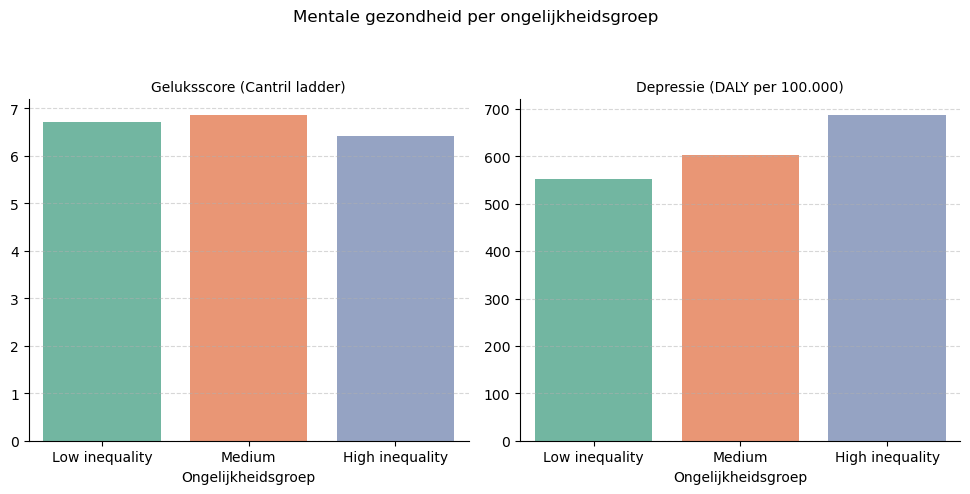

In [12]:
# Gemiddeldes per groep
group_means = mean_df.groupby('gini_group')[['ladder_score', 'depression_daly']].mean().reset_index()

# Omzetten naar lange vorm
melted = group_means.melt(id_vars='gini_group', var_name='Indicator', value_name='Gemiddelde waarde')

# Labels aanpassen voor duidelijkheid
indicator_labels = {
    'ladder_score': 'Geluksscore (Cantril ladder)',
    'depression_daly': 'Depressie (DALY per 100.000)'
}
melted['Indicator'] = melted['Indicator'].replace(indicator_labels)

# Facet barplots
g = sns.catplot(
    data=melted,
    kind='bar',
    x='gini_group',
    y='Gemiddelde waarde',
    col='Indicator',
    palette='Set2',
    sharey=False
)

g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Mentale gezondheid per ongelijkheidsgroep')
g.set_titles('{col_name}')
g.set_axis_labels('Ongelijkheidsgroep', '')
g.set_xticklabels(rotation=0)
for ax in g.axes.flatten():
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()



**Figuur 1.2 : Mentale gezondheid per ongelijkheidsgroep** 
 
Deze visualisatie toont het verband tussen inkomensongelijkheid en mentaal welzijn, uitgesplitst per ongelijkheidsgroep op basis van de Gini-coëfficiënt (laag, gemiddeld, hoog). De linker grafiek toont de gemiddelde geluksscore (Cantril ladder; schaal 0–10), terwijl de rechter grafiek het gemiddelde aantal ziektelastjaren (DALY's) door depressieve stoornissen per 100.000 inwoners weergeeft. De x-as toont de mate van ongelijkheid, en de y-assen geven respectievelijk het geluksniveau en het aantal DALY’s aan. De grafiek laat zien dat landen met hogere ongelijkheid gemiddeld minder gelukkig zijn en meer depressielast kennen. Dit ondersteunt de hypothese dat ongelijkheid negatieve psychologische effecten heeft via verhoogde stress en sociale uitsluiting.

## Conclusie

De visualisaties in dit perspectief tonen hoe inkomensongelijkheid samenhangt met slechter mentaal welzijn. In landen met een hoge Gini-coëfficiënt komt depressie vaker voor en scoren mensen gemiddeld lager op de Cantril ladder van ervaren geluk. Dit ondersteunt twee centrale mechanismen: ten eerste vergroot ongelijkheid de statusstress en sociale vergelijking, wat leidt tot mentale druk. Ten tweede ondermijnt ongelijkheid de sociale cohesie en het vertrouwen in anderen, wat het algemeen welzijn verlaagt.
De data tonen dat ongelijkheid het psychologisch en sociaal functioneren van samenlevingen aanzienlijk beïnvloedt.



## Perspectief 2: politiek

Dit perspectief vertrekt vanuit het idee dat intense politieke betrokkenheid mogelijk samenhangt met een lager niveau van geluk binnen een samenleving. Het onderliggende argument is dat in samenlevingen waar politiek een dominante rol speelt in het dagelijks leven van burgers, dit gepaard kan gaan met gevoelens van stress, verdeeldheid of machteloosheid. Politiek wordt dan niet gezien als iets verbindends, maar als een bron van conflict, frustratie of onzekerheid. 

Het uitgangspunt van deze analyse is dus:  
**Hoe belangrijker mensen politiek vinden in hun leven, hoe lager gemiddeld hun ervaren geluk.**

## Gebruikte datasets

### 1. **World Values Survey (2022)**  
**Variabele:** _Very important in life: Politics_

Deze dataset komt van een wereldwijd surveyproject dat meet hoe belangrijk mensen verschillende levensaspecten vinden, waaronder politiek. De specifieke variabele die wij gebruiken toont per land welk percentage van de bevolking politiek bijvoorbeeld als **"zeer belangrijk"** beschouwt in hun leven. Deze maat laat indirect zien in hoeverre mensen politiek als bepalend of ingrijpend ervaren binnen hun samenleving. 

> **Doel in deze analyse:**  
> Helpt inschatten hoe politiek "aanwezig" of "dominant" is in het leven van mensen per land.

### 2. **Gallup World Poll / Our World in Data (2022)**  
**Variabele:** _Cantril ladder score_

De Cantril-ladder is een bekende methode om geluk of levensvoldoening te meten. Mensen wordt gevraagd hun leven voor te stellen als een ladder van 0 (slechtst mogelijke leven) tot 10 (best mogelijke leven), en aan te geven op welke trede ze zichzelf op dit moment plaatsen. Dit levert een gemiddelde geluksscore per land op.

> **Doel in deze analyse:**  
> Maakt het mogelijk om per land te bepalen hoe gelukkig mensen zich voelen, en dat te koppelen aan politieke betrokkenheid.


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

## Onderzoeksvraag en Doel

In dit project wordt onderzocht of er een relatie bestaat tussen politieke betrokkenheid en het geluksniveau in verschillende landen. 

De centrale hypothese luidt:

**Hoe belangrijker mensen politiek vinden in hun dagelijks leven, hoe ongelukkiger ze zich gemiddeld voelen.**

Om deze hypothese te toetsen, zijn twee datasets gebruikt:

- **Dataset 1:** *how-important-politics-is-in-your-life.csv*  
  Bevat per land het percentage mensen dat politiek als "zeer belangrijk" aanduidt in hun leven.

- **Dataset 2:** *happiness-cantril-ladder.csv*  
  Bevat per land de gemiddelde geluksscore, gemeten via de Cantril-ladder (schaal van 0 tot 10).

Het doel van dit onderzoek is om deze twee datasets te koppelen, te analyseren en visueel weer te geven, om inzicht te krijgen in de mogelijke samenhang tussen politieke betrokkenheid en ervaren geluk op internationaal niveau.


## Stap 1: Inladen van de dataset over politiek belang

We beginnen dit project door de dataset te laden die meet hoe belangrijk mensen politiek vinden in hun leven.  
Omdat we deze data willen vergelijken met geluksscores uit hetzelfde jaar, filteren we de dataset op **alleen het jaar 2022**.  
Op deze manier zorgen we voor een eerlijke, tijdsgebonden vergelijking tussen landen.

Uit de dataset behouden we enkel de kolom die het percentage weergeeft van mensen die politiek als **"zeer belangrijk"** beschouwen.  
Deze kolom wordt hernoemd naar `"Very Important %"` om de interpretatie te vergemakkelijken en de leesbaarheid van latere analyses te verbeteren.


In [ ]:
# Pad naar politieke dataset
politiek_path = "data/how-important-politics-is-in-your-life.csv"
df_pol = pd.read_csv(politiek_path)

# Filter op jaar 2022
df_pol_2022 = df_pol[df_pol["Year"] == 2022].copy()

# Pak alleen het percentage mensen dat politiek "zeer belangrijk" vindt
df_very = df_pol_2022[["Entity", "Very important in life: Politics"]].dropna()

# Hernoem kolom voor duidelijkheid
df_very = df_very.rename(columns={"Very important in life: Politics": "Very Important %"})


### Resultaat
Een dataframe met landen en het percentage mensen dat politiek als "zeer belangrijk" beschouwt in het jaar 2022.

## Stap 2: Inladen van de dataset over geluk

Vervolgens laden we de dataset met gemiddelde geluksscores, gemeten aan de hand van de **Cantril-ladder**.  
Deze schaal loopt van 0 (slechtst mogelijke leven) tot 10 (best mogelijke leven), en geeft aan hoe mensen hun leven evalueren.

Net als bij de politieke dataset filteren we ook hier op **het jaar 2022**, zodat de data vergelijkbaar blijft.  
We selecteren enkel de relevante kolommen: de landnaam en de bijbehorende Cantril-score.


In [ ]:
# Pad naar geluksdataset
geluk_path = "data/happiness-cantril-ladder.csv"
df_geluk = pd.read_csv(geluk_path)

# Filter op jaar 2022 en relevante kolommen
df_geluk_2022 = df_geluk[df_geluk["Year"] == 2022][["Entity", "Cantril ladder score"]].dropna()


### Resultaat
Een dataframe met landen en hun gemiddelde geluksscore in 2022.

## Stap 3: Mergen van beide datasets

We willen per land zowel het percentage mensen dat politiek als zeer belangrijk beschouwt, als de gemiddelde geluksscore kunnen vergelijken.  
Daarom voegen we de twee datasets samen op basis van de kolom **“Entity”**, die de landnamen bevat.  
Na het mergen bevat elke rij in de nieuwe dataset informatie over zowel politieke betrokkenheid als geluk voor dat land.


In [ ]:
# Merge op landnaam
merged = pd.merge(df_very, df_geluk_2022, on="Entity")

# Bekijk de eerste paar rijen
print(merged.head())


      Entity  Very Important %  Cantril ladder score
0    Albania          5.375286                 5.277
1  Argentina          7.527421                 6.024
2    Armenia         12.755730                 5.342
3  Australia         10.337860                 7.095
4    Austria         11.372800                 7.097


### Resultaat
Een gecombineerde dataset met per land:

- **Very Important %** – het percentage mensen dat politiek als zeer belangrijk beschouwt  
- **Cantril ladder score** – de gemiddelde geluksscore van mensen in dat land

## Stap 4: Correlatie berekenen

We willen nu onderzoeken of er een statistische relatie bestaat tussen deze twee variabelen.  
Hiervoor gebruiken we de **Pearson-correlatiecoëfficiënt**, die meet of er een lineair verband is tussen twee variabelen en hoe sterk dat verband is.  
Een negatieve waarde van r betekent dat een hoger politiek belang samenhangt met een lager geluk.


In [ ]:
from scipy.stats import pearsonr

# Bepaal de correlatie
x = merged["Very Important %"]
y = merged["Cantril ladder score"]
r, p = pearsonr(x, y)

print(f"r = {r:.4f}, p = {p:.4f}")


r = -0.3779, p = 0.0005


## Argument 1: Hoge politieke betrokkenheid weerspiegelt gevoel van urgentie in crisissamenlevingen

In landen waar burgers politiek als “zeer belangrijk” ervaren, speelt vaak een gevoel van urgentie of crisis. Denk aan economische instabiliteit, corruptie, conflict of polarisatie.  
Mensen wenden zich in zulke contexten intensiever tot politiek: niet omdat ze zich empowered voelen, maar omdat de omstandigheden hen daartoe dwingen.  
De overheid wordt dan gezien als bron van zowel hoop als frustratie. Deze verhoogde aandacht voor politiek weerspiegelt een stressvolle leefomgeving, waarin het geluksgevoel onder druk staat.

### Onderbouwing uit de data

- **Negatieve correlatie** tussen politiek belang en Cantril-geluksscore:  
  *r = –0.378*, *p = 0.0005*

- In landen met **extreem hoge politieke betrokkenheid** (zoals Egypte, Ghana en Zimbabwe), liggen de geluksscores **ver onder het wereldgemiddelde**

- Deze landen scoren vaak ook laag op indicatoren zoals politieke stabiliteit, persvrijheid of inkomenszekerheid  
  (*al zijn die hier niet direct gemeten, ze kunnen interessant zijn voor vervolgonderzoek*)

### Interpretatie

De burger die dagelijks met politiek bezig is, doet dat niet altijd uit vrije keuze.  
In maatschappijen waar fundamentele systemen wankelen, wordt politiek onontkoombaar.  
Deze constante confrontatie met politieke kwesties kan afbreuk doen aan het gevoel van autonomie, veiligheid en toekomstperspectief: allemaal belangrijke bouwstenen van welzijn en geluk.


### Resultaat

- **r** vertelt hoe sterk het verband is.  
  *r < 0* betekent een **negatief verband**: hoe belangrijker mensen politiek vinden, hoe lager het geluk.
  
- **p** vertelt of het verband **statistisch significant** is.  
  *p < 0.05* betekent dat het verband **waarschijnlijk niet door toeval komt**.

### Stap 5: Visualisatie van de relatie

We maken een scatterplot waarin:

- Elk land wordt weergegeven als **een punt** op basis van:
  - **X-as**: percentage mensen dat politiek als "zeer belangrijk" ervaart
  - **Y-as**: gemiddelde geluksscore volgens de Cantril-ladder

- Een **regressielijn** toont de algemene trend in de data

- Er worden **annotaties toegevoegd** bij landen met extreme waarden, zoals zeer hoge betrokkenheid of zeer laag geluk


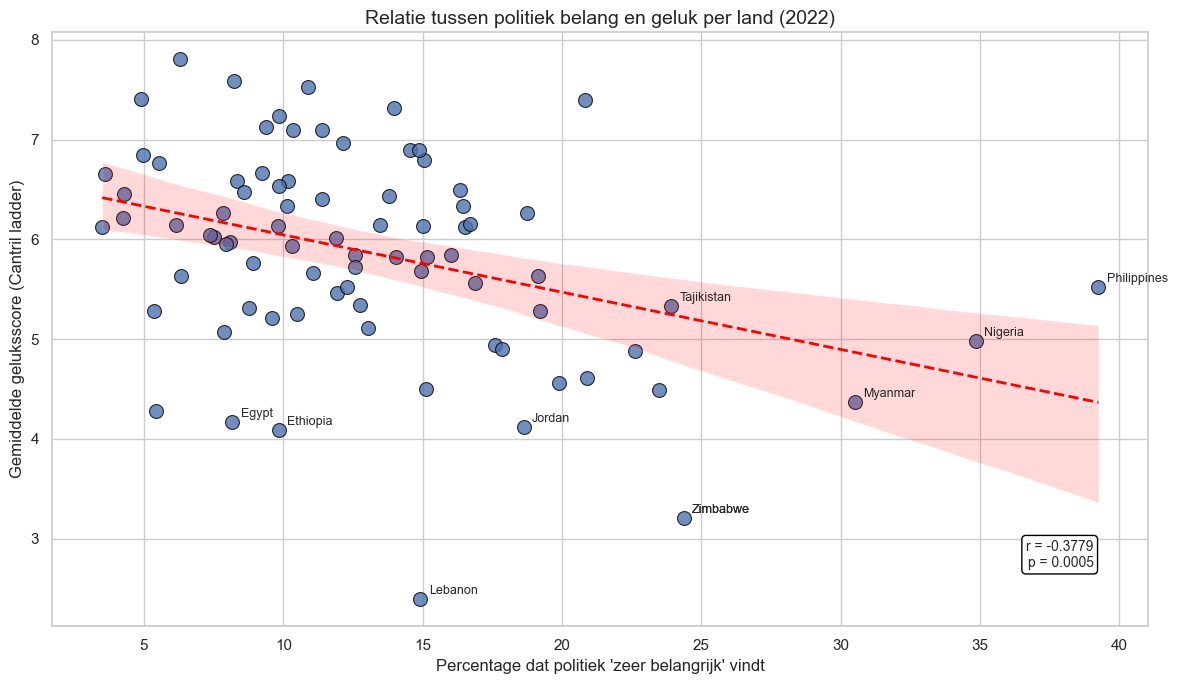

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Maak een kopie van de dataset
subset = merged.copy()

# Visualisatie
plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")

# Puntenplot
sns.scatterplot(
    data=subset,
    x="Very Important %",
    y="Cantril ladder score",
    s=100,
    alpha=0.8,
    edgecolor="black"
)

# Regressielijn
sns.regplot(
    data=subset,
    x="Very Important %",
    y="Cantril ladder score",
    scatter=False,
    color="red",
    line_kws={"linewidth": 2, "linestyle": "dashed"}
)

# Annotaties: landen met hoogste belang en laagste geluk
top_label_landen = subset.sort_values("Very Important %", ascending=False).head(5)
top_label_landen = pd.concat([
    top_label_landen,
    subset.sort_values("Cantril ladder score", ascending=True).head(5)
])

for _, row in top_label_landen.iterrows():
    plt.text(
        row["Very Important %"] + 0.3,
        row["Cantril ladder score"] + 0.05,
        row["Entity"],
        fontsize=9
    )

# Titels + correlatie
plt.title("Relatie tussen politiek belang en geluk per land (2022)", fontsize=14)
plt.xlabel("Percentage dat politiek 'zeer belangrijk' vindt")
plt.ylabel("Gemiddelde geluksscore (Cantril ladder)")

plt.text(
    0.95, 0.1,
    f"r = {r:.4f}\np = {p:.4f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    ha='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

plt.tight_layout()
plt.show()


### Conclusie

De visualisatie toont een duidelijke **negatieve correlatie**:

→ Hoe belangrijker mensen politiek vinden in hun dagelijks leven,  
   hoe lager het gemiddelde geluksniveau in dat land.

Deze observatie ondersteunt het argument dat sterke politieke betrokkenheid  
niet altijd duidt op interesse of participatie uit vrijheid,  
maar juist op een gevoel van maatschappelijke onrust of urgentie.  
Wanneer mensen zich intensief bezighouden met politiek,  
kan dit voortkomen uit zorgen, ontevredenheid of stress:
factoren die het subjectieve welzijn verlagen.


In [ ]:
# Sorteer op hoogste politieke betrokkenheid
top_hoog = merged.sort_values("Very Important %", ascending=False).head(10)
# Sorteer op laagste politieke betrokkenheid
top_laag = merged.sort_values("Very Important %", ascending=True).head(10)

# Bereken gemiddelde geluksscore per groep
gem_hoog = top_hoog["Cantril ladder score"].mean()
gem_laag = top_laag["Cantril ladder score"].mean()

print(f" Gemiddelde geluksscore (hoogste politieke betrokkenheid): {gem_hoog:.2f}")
print(f" Gemiddelde geluksscore (laagste politieke betrokkenheid): {gem_laag:.2f}")


 Gemiddelde geluksscore (hoogste politieke betrokkenheid): 4.93
 Gemiddelde geluksscore (laagste politieke betrokkenheid): 6.22


Deze cijfers ondersteunen het idee dat **intensieve politieke betrokkenheid geassocieerd is met een lager gemiddeld geluksgevoel**:
niet per se omdat politiek op zichzelf ongelukkig maakt,  
maar omdat het belang dat eraan wordt gehecht een indicatie kan zijn van **maatschappelijke spanningen** of **ontevredenheid**.

Met andere woorden: politieke betrokkenheid fungeert hier mogelijk als signaal van bredere sociale of economische problemen,  
en niet als bron van welzijn.
